In [ ]:
# default_exp function_approximation

# Function Approximation

> function approximation playground

`Go to Runtime -> Change runtime type and make sure Hardward accelerator is set to GPU`

In [ ]:
# export
from abc import ABC, abstractmethod
from fastcore.test import *
import jsmltools
from jsmltools import data_generator
from nbdev.showdoc import *
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

test_eq(tf.__version__, "2.2.0")

In [ ]:
# export

class KerasPipeline(ABC):
    """Scafolding for a tf.keras model building pipeline.
    
    This base class will contain scafolding for all pipelines
    used. The goal of this base class is mainly to add safeguard
    and assumption enforcement.
    """
    def __init__(self):
        # safe guard: to ensure that various session don't collide
        keras.backend.clear_session()
        self.train_x, self.train_y, self.test_x, self.test_y = None, None, None, None
        self.model = None
        self.evaluation = None
        self.train_history = None
    
    @abstractmethod
    def get_data(self):
        pass

    @abstractmethod
    def build_model(self):
        pass
    
    @abstractmethod
    def run_training(self):
        pass
    
    @abstractmethod
    def evaluate_pipeline(self):
        pass
    
    def plot_model_shapes(self, show_shapes=True, show_layer_names=True):
        return keras.utils.plot_model(self.model, 
                                      show_shapes=show_shapes, 
                                      show_layer_names=show_layer_names)

    def keras_model_summary(self):
        return self.model.summary()
        
    def __call__(self, verbose=0):
        ########################################
        # step 1: get data 
        ########################################
        self.get_data()
        # checking that self.get_data() is implimented as expected
        assert list(
            map(lambda x: x is not None, [self.train_x, self.train_y, self.test_x, self.test_y])
            )  == [True] * 4 

        ########################################
        # step 2: build model
        ########################################
        self.build_model()
        # checking that self.model() is implimented as expected
        assert self.model is not None
        
        ########################################
        # step 3: train model
        ########################################        
        print("\n", "=-="*10, "MODEL TRAINING", "=-="*10, "\n")
        self.run_training(verbose)
        # checking that self.train() is implimented as expected
        assert self.train_history is not None
        assert self.model._is_compiled == True

        if verbose > 0:
            print("\n", "=-="*10, "MODEL SUMMARY", "=-="*10, "\n")
            self.keras_model_summary()

        ########################################
        # step 4: evaluate pipeline
        ########################################
        print("\n", "=-="*10, "PIPELINE EVALUATION", "=-="*10, "\n")
        self.evaluate_pipeline()
        # checking that self.evaluate() is implimented as expected
        assert self.evaluation is not None
    
        # TODO (jovsa): run tests that ensure pipeline trains model above a benchmark

### Using High Level APIs

#### Using tf.keras Functional API

In [ ]:
#export
class HighLevelKerasPipeline(KerasPipeline):
    def __init__(self, sample_n, additional_y):
        self.sample_n = sample_n
        self.additional_y = additional_y
        super().__init__()
    
    def get_data(self):
        data = data_generator.MNISTDataGenerator(self.additional_y)
        datasets  = data(self.sample_n)
        self.train_x, self.train_y, self.test_x, self.test_y = datasets

    def build_model(self):
        inputs = keras.Input(shape=(784, 1), name="inputs")
        # Rescale images to [0, 1]
        x = Rescaling(scale=1./255)(inputs)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(units=64, activation='relu')(x)
        output = keras.layers.Dense(units=10, activation='softmax', name="output")(x)

        self.model = keras.Model(inputs=inputs, outputs=output)

    def run_training(self, verbose):
        self.model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=[keras.metrics.SparseCategoricalAccuracy()])
        
        self.train_history = self.model.fit(
            x=self.train_x, y=self.train_y, epochs=10, batch_size=64, 
            verbose=verbose, validation_split=0.1)

    def evaluate_pipeline(self):
        self.evaluation = self.model.evaluate(x=self.test_x, y=self.test_y)

In [ ]:
# single target pipeline
single_target_pipeline = HighLevelKerasPipeline(sample_n=1000, additional_y=0)
single_target_pipeline(verbose=2)


 =-==-==-==-==-==-==-==-==-==-= MODEL TRAINING =-==-==-==-==-==-==-==-==-==-= 

Epoch 1/10
15/15 - 0s - loss: 1.7374 - sparse_categorical_accuracy: 0.5011 - val_loss: 1.2981 - val_sparse_categorical_accuracy: 0.6700
Epoch 2/10
15/15 - 0s - loss: 1.0107 - sparse_categorical_accuracy: 0.7889 - val_loss: 0.9551 - val_sparse_categorical_accuracy: 0.7500
Epoch 3/10
15/15 - 0s - loss: 0.7250 - sparse_categorical_accuracy: 0.8533 - val_loss: 0.8367 - val_sparse_categorical_accuracy: 0.7600
Epoch 4/10
15/15 - 0s - loss: 0.5667 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.6516 - val_sparse_categorical_accuracy: 0.8800
Epoch 5/10
15/15 - 0s - loss: 0.4684 - sparse_categorical_accuracy: 0.8933 - val_loss: 0.5874 - val_sparse_categorical_accuracy: 0.8400
Epoch 6/10
15/15 - 0s - loss: 0.3970 - sparse_categorical_accuracy: 0.9089 - val_loss: 0.5440 - val_sparse_categorical_accuracy: 0.8500
Epoch 7/10
15/15 - 0s - loss: 0.3448 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.4676 - val_spa

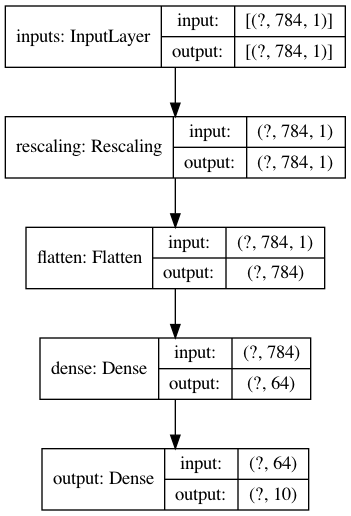

In [ ]:
single_target_pipeline.plot_model_shapes()

## References
* [Keras for Engineers](https://colab.research.google.com/drive/1lWUGZarlbORaHYUZlF9muCgpPl8pEvve)
* [Keras for Researchers](https://colab.research.google.com/drive/169PfzM0kvtA5UP4k6Sl1yCG9tsE2MLia#scrollTo=4T2NXVLa9Cld)